# Parsing tutorial

## Hailo parsing example from Tensorflow CKPT to HAR

This tutorial will walk you through parsing Tensorflow checkpoints to the HAR format (Hailo Archive). HAR is a tar.gz archive file that contains the representation of the graph structure and the weights that are deployed to the Hailo hardware.

Note:
**Running this code in Jupyter notebook is recommended**, see the Introduction tutorial for more details.

Note:
This section demonstrates the Python APIs for Hailo Parser.
You could also use the CLI: try `hailo parser {tf, ckpt, tf2, onnx} --help`.
More details on Dataflow Compiler User Guide / Building Models / Profiler and other command line tools.

In [1]:
%matplotlib inline
import tensorflow as tf

from IPython.display import SVG
from hailo_sdk_client import ClientRunner, NNFramework

Choose the checkpoint files to be used throughout the tutorial:

The main API of the Dataflow Compiler that the user interacts with is the ClientRunner class (see the API Reference section on the Dataflow Compiler user guide for more information).

First, initialize a ClientRunner and use the translate_tf_model method. 

Arguments:

* model_path
* model_name to use
* start_node_names (list of str, optional): Name of the first node to parse.
* end_node_names (list of str, optional): List of nodes, that the parsing can stop after all of them are parsed.

For translating the model, supplying start and end node names might be crucial. You can use the `hailo tb` tool or any other model visualization tool to visualize the model and locate the nodes.

In [2]:
#tf2_model_path = './saved_model.pb'
#model_name = 'model1'

# Parsing the model to Hailo format
#runner = ClientRunner(hw_arch='hailo8')
#hn, npz = runner.translate_tf_model(tf2_model_path, model_name, start_node_names=['FeatureExtractor/detection_mnasfpn_v1_a_320_1/mnasnet-a1/mnas_net_model/mnas_stem/conv2d/Conv2D'], end_node_names=['Postprocessor/raw_box_encodings','Postprocessor/scale_logits'], nn_framework=NNFramework.TENSORFLOW2)

In [3]:
!python3 -m tf2onnx.convert --tfjs ./tf-js/model.json --output model.onnx --opset 15 --inputs "Preprocessor/map/TensorArrayStack/TensorArrayGatherV3:0"

2022-12-20 22:11:13.374024: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-20 22:11:13.374044: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/usr/lib/python3.8/runpy.py:127: RuntimeWarning: 'tf2onnx.convert' found in sys.modules after import of package 'tf2onnx', but prior to execution of 'tf2onnx.convert'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
2022-12-20 22:11:14.124572: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-12-20 22:11:14.124589: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-20 22:11:14.124602: 

In [4]:
!python3 -m onnxsim ./model.onnx ./model.sim.onnx --skip-fuse-bn --overwrite-input-shape "1,512,512,3"

Your model contains "Tile" ops or/and "ConstantOfShape" ops. Folding these ops 
can make the simplified model much larger. If it is not expected, please specify
"--no-large-tensor" (which will lose some optimization chances)
Simplifying...
Finish! Here is the difference:
┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃                   ┃ Original Model ┃ Simplified Model ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ Add               │ 38             │ 35               │
│ Cast              │ 17             │ 0                │
│ Concat            │ 19             │ 3                │
│ Conv              │ 134            │ 134              │
│ Exp               │ 2              │ 2                │
│ Gather            │ 5              │ 0                │
│ GlobalAveragePool │ 8              │ 8                │
│ GlobalMaxPool     │ 4              │ 4                │
│ MaxPool           │ 13             │ 13               │
│ Mul               │ 33        

# Parsing the model to Hailo format


In [5]:
model_name='vertexAI'

In [27]:
runner = ClientRunner(hw_arch='hailo8')
hn, npz = runner.translate_onnx_model(
    './model.sim.onnx', model_name,
    start_node_names=['FeatureExtractor/detection_mnasfpn_v1_a_320_1/mnasnet-a1/mnas_net_model/mnas_stem/Relu_BiasAdd__8'],
    #end_node_names=['FeatureExtractor/detection_mnasfpn_v1_a_320_1/mnasnet-a1/mnas_net_model/mnas_blocks_5/batch_normalization_2/FusedBatchNormV3_BiasAdd__46']
    #end_node_names=['FeatureExtractor/detection_mnasfpn_v1_a_320_1/mnasnet-a1/mnas_net_model/mnas_blocks_5/Add']        
    #end_node_names=['FeatureExtractor/detection_mnasfpn_v1_a_320_1/mnasnet-a1/mnas_net_model/mnas_blocks_11/Add','FeatureExtractor/detection_mnasfpn_v1_a_320_1/feature_network/fpn_cells/cell_0/sub_policy3/op_after_combine7/Relu_BiasAdd__95','FeatureExtractor/detection_mnasfpn_v1_a_320_1/feature_network/fpn_cells/cell_0/sub_policy6/resample_0_0_10/conv2d/BiasAdd_BiasAdd__48']
    #end_node_names=['FeatureExtractor/detection_mnasfpn_v1_a_320_1/mnasnet-a1/mnas_net_model/mnas_blocks_11/Add','FeatureExtractor/detection_mnasfpn_v1_a_320_1/feature_network/fpn_cells/cell_0/sub_policy3/op_after_combine7/Relu_BiasAdd__95','FeatureExtractor/detection_mnasfpn_v1_a_320_1/feature_network/fpn_cells/cell_0/sub_policy6/resample_0_0_10/conv2d/BiasAdd_BiasAdd__48','FeatureExtractor/detection_mnasfpn_v1_a_320_1/feature_network/fpn_cells/cell_0/sub_policy1/resample_0_1_5/max_pooling2d/MaxPool',
    #               'FeatureExtractor/detection_mnasfpn_v1_a_320_1/feature_network/fpn_cells/cell_0/sub_policy8/resample_0_1_12/max_pooling2d/MaxPool',
    #                'FeatureExtractor/detection_mnasfpn_v1_a_320_1/feature_network/fpn_cells/cell_0/sub_policy5/resample_0_1_9/max_pooling2d/MaxPool',
    #                'FeatureExtractor/detection_mnasfpn_v1_a_320_1/mnasnet-a1/mnas_net_model/mnas_blocks_15/batch_normalization_2/FusedBatchNormV3_BiasAdd__123']
    end_node_names=['FeatureExtractor/detection_mnasfpn_v1_a_320_1/feature_network/resample_p6/max_pooling2d/MaxPool',
                    'FeatureExtractor/detection_mnasfpn_v1_a_320_1/feature_network/fpn_cells/cell_0/sub_policy2/resample_0_2_6/conv2d/BiasAdd_BiasAdd__125',
                    'FeatureExtractor/detection_mnasfpn_v1_a_320_1/feature_network/fpn_cells/cell_0/sub_policy1/resample_1_2_5/conv2d/BiasAdd_BiasAdd__126',
                    'FeatureExtractor/detection_mnasfpn_v1_a_320_1/feature_network/fpn_cells/cell_0/sub_policy0/resample_0_2_4/conv2d/BiasAdd_BiasAdd__124',
                    'FeatureExtractor/detection_mnasfpn_v1_a_320_1/feature_network/fpn_cells/cell_0/sub_policy8/resample_0_1_12/max_pooling2d/MaxPool',
                    'FeatureExtractor/detection_mnasfpn_v1_a_320_1/feature_network/fpn_cells/cell_0/sub_policy7/resample_0_1_11/conv2d/BiasAdd_BiasAdd__88',
                    'FeatureExtractor/detection_mnasfpn_v1_a_320_1/feature_network/fpn_cells/cell_0/sub_policy6/resample_1_1_10/conv2d/BiasAdd_BiasAdd__87',
                    'FeatureExtractor/detection_mnasfpn_v1_a_320_1/feature_network/fpn_cells/cell_0/sub_policy5/resample_0_1_9/max_pooling2d/MaxPool',
                    'FeatureExtractor/detection_mnasfpn_v1_a_320_1/feature_network/fpn_cells/cell_0/sub_policy1/resample_0_1_5/max_pooling2d/MaxPool',
                    'FeatureExtractor/detection_mnasfpn_v1_a_320_1/feature_network/fpn_cells/cell_0/sub_policy3/op_after_combine7/Relu_BiasAdd__95',
                    'FeatureExtractor/detection_mnasfpn_v1_a_320_1/feature_network/fpn_cells/cell_0/sub_policy6/resample_0_0_10/conv2d/BiasAdd_BiasAdd__48'                
                    ]

)

[info] Translation completed on ONNX model vertexAI
[info] Initialized runner for vertexAI


## Hailo Archive

Hailo Archive is a tar.gz archive file that captures the "state" of the model - the files and attributes used in a given stage from parsing to compilation.
You can use the `save_har` method to save the runner's state in any stage and `load_har` method to load a saved state to an uninitialized runner.

The initial HAR file includes:
- HN file, which is a JSON-like representation of the graph structure that is deployed to the Hailo hardware.
- NPZ file, which includes the weights of the model.

Save the parsed model in a Hailo Archive file:

In [22]:
hailo_model_har_name = '{}_hailo_model.har'.format(model_name)
runner.save_har(hailo_model_har_name)

Visualize the graph with the visualizer tool:

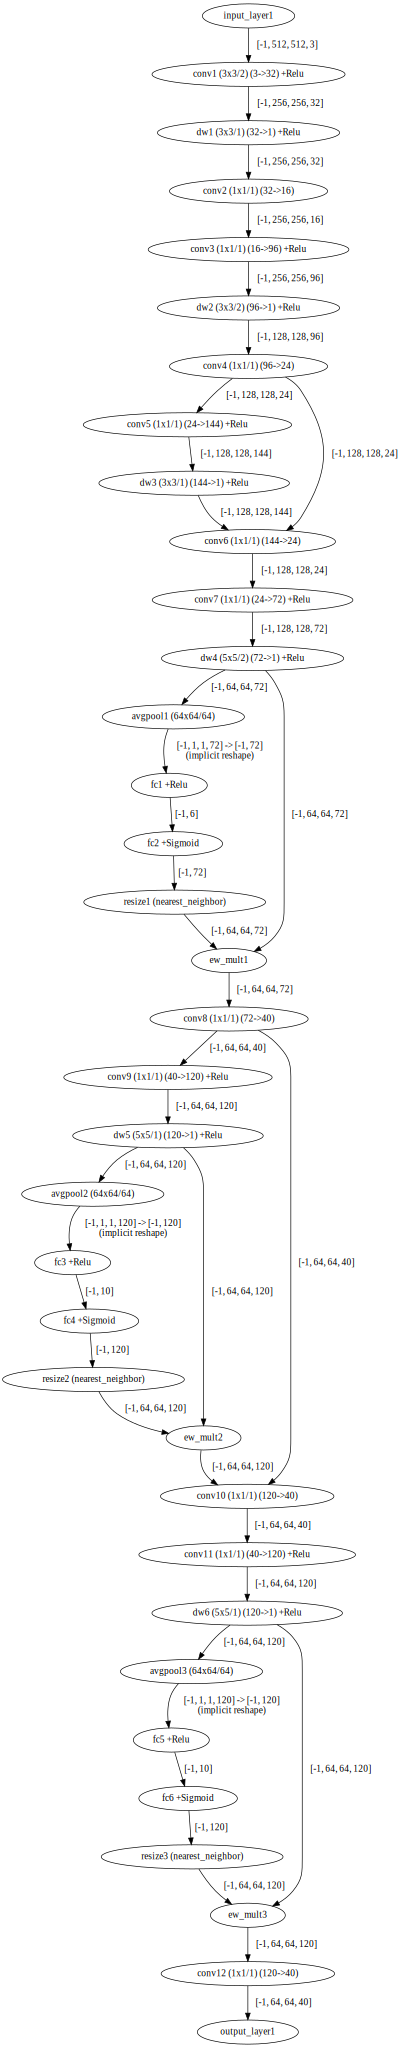

In [23]:
!hailo visualizer {hailo_model_har_name} --no-browser
SVG('out.svg')

Run the profiler tool:

This command will pop-open the HTML report in the browser.

In [ ]:
!hailo profiler {hailo_model_har_name}